# Facebook: Paid vs Unpaid Posts

### Introduction:
Background: Facebook is one of the biggest social media platforms known to society, and it is a great place for businesses to reach consumers globally. It is a great way to collect data on different metrics and, specifically, we curious to see if we could predict whether a post is paid or unpaid. Hence, we chose two different metrics for Facebook posts that we thought would correlate the heaviest, lifetime post total reach and lifetime people who have liked the page and engaged with the post, to make a prediction on whether the post was paid or unpaid.

Question: How well do the two variables, lifetime post total reach and lifetime people who have liked the page and engaged with the post, predict if a post was paid or unpaid? In other words, which of the three has the highest accuracy of predicting a paid/unpaid post: 1. the first variable, 2. the second variable or 3. together?

Dataset: The dataset we have is from 2014 Facebook posts of a renowned cosmetic brand, and it shows the type of post (paid vs unpaid) as well as information on it, from the number of likes and shares to total impressions. This will be done through splitting the data into a training and testing set, and building a classifier thereafter.

### Methods and Results:

##### Step 1
The following packages are loaded using the library function to be able to use the functions necessary to build, tune, and estimate the accuracy of the classifier.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

##### Step 2
The dataset is downloaded from the UCI Machine Learning Repository. In this project, we will be using the 2014 Facebook page of a renowned cosmetic brand. The as_factor() function is used to convert the Paid column into a factor instead of an integer. With this, it can now be used as a class/label that observations can be categorized into. Moreober, the select() function is used to select the columns, Lifetime Post Total Reach, and Lifetime People who have liked your Page and engaged with your post, as the chosen predictors for our classifier. Furthermore, in this dataset, 0 = unpaid and 1 = paid.

In [18]:
set.seed(3060)
options(repr.plot.width = 8, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp, mode="wb")
unzip(temp, "dataset_Facebook.csv")
facebook <- select(mutate(read.delim('dataset_Facebook.csv', sep=';'), Paid=as_factor(Paid)), Paid, Lifetime_Post = Lifetime.Post.Total.Reach, Lifetime_Like_Engage = Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post)
facebook

Paid,Lifetime_Post,Lifetime_Like_Engage
<fct>,<int>,<int>
0,2752,119
0,10460,1108
0,2413,132
⋮,⋮,⋮
0,3778,363
0,4156,370
NA,4188,316


##### Step 3
The dataset is then randomly shuffled and split into a training and testing set, wherein the training set consists of 75% of the dataset whereas the testing set consists of the remaining 25%. The training set is used to build and tune the classifier, and the testing set is used to estimate the accuracy of this classifier in predicting observations. This is where we also tell the classifier that the class we want to predict is the Paid column.

In [3]:
#splitting the data into a training and testing dataset
facebook_split <- initial_split(facebook, prop = 0.75, strata = Paid) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

##### Step 4
Using the training dataset, we build and tune the classifier that we will use to predict observations. We do 5-fold cross-validation, using the vfold_cv() function, to build the model to establish the number of neighbours that would be best to achieve the highest estimated accuracy. It is also important that we scale and center the chosen predictors to ensure that no variable would have a higher influence in the prediction due to their larger scale. 

In [4]:
#building and tuning the classifier
facebook_recipe <- recipe(Paid ~ Lifetime_Post + Lifetime_Like_Engage, data = facebook_train) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = Paid)

knn_tune<- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
      set_engine('kknn') %>%
      set_mode('classification')

knn_results <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = facebook_vfold, grid = 10) %>%
      collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6080000,5,0.01496663,Model01
2,roc_auc,binary,0.5230159,5,0.04059705,Model01
4,accuracy,binary,0.6186667,5,0.02004440,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,binary,0.5602293,5,0.01222828,Model09
14,accuracy,binary,0.6906667,5,0.01292715,Model10
14,roc_auc,binary,0.5652557,5,0.02241967,Model10


##### Step 5
Because we only care about the mean of the accuracy, we use the filter() function to filter out these specific rows under the .metric column. We then plot out the graph wherein the x-axis consists of the neighbors column and the y-axis contains the respective means of these neighbours. 

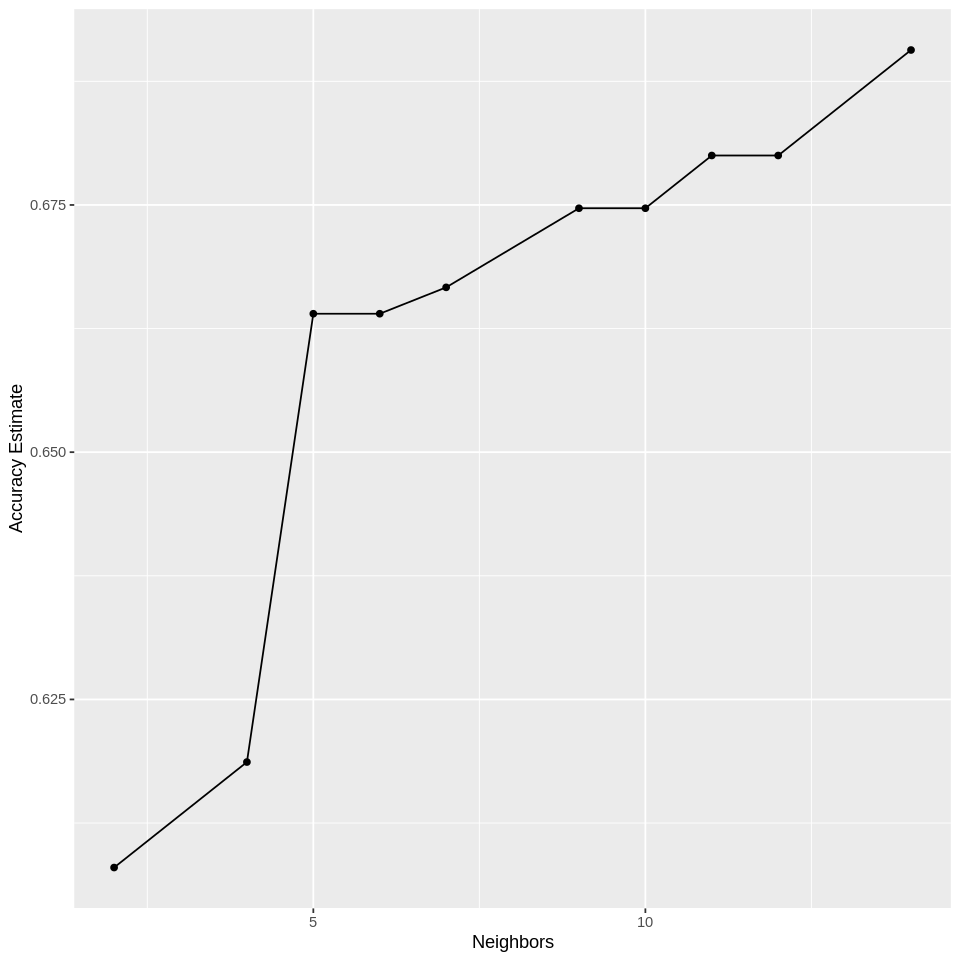

In [5]:
#choosing the correct number of neighbours
accuracies <- knn_results %>% 
      filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k

In [6]:
#building classifier with chosen number of neighbours
k_max <- accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)
k_max

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = k_max) %>%
      set_engine('kknn') %>%
      set_mode('classification')

[1] 14

In [7]:
#estimating the classifier's validation/prediction accuracy
facebook_fit <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = facebook_vfold)

facebook_metrics<-collect_metrics(facebook_fit)
facebook_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.6906667,5,0.01292715
roc_auc,binary,0.5652557,5,0.02241967


In [8]:
#estimating the accuracy of the classifier on the testing data
facebook_fit_test <- workflow() %>%
    add_recipe(facebook_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = facebook_train)

facebook_test_prediction <- predict(facebook_fit_test, facebook_test) %>%
    bind_cols(facebook_test)

facebook_metrics <- facebook_test_prediction %>%
    metrics(truth = Paid, estimate = .pred_class)
facebook_metrics

confusion <- facebook_test_prediction %>%
    conf_mat(truth = Paid, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70161290
kap,binary,0.07200647


          Truth
Prediction  0  1
         0 82 29
         1  8  5

In [9]:
#scale the variables
facebook_scaled <- facebook %>%
    mutate(Lifetime_Post = scale(Lifetime_Post, center = TRUE), Lifetime_Like_Engage = scale(Lifetime_Like_Engage, center = TRUE))
facebook_scaled

Paid,Lifetime_Post,Lifetime_Like_Engage
<fct>,"<dbl[,1]>","<dbl[,1]>"
0,-0.4903682,-0.8013146
0,-0.1514178,0.8127847
0,-0.5052754,-0.7800980
⋮,⋮,⋮
0,-0.4452511,-0.4030940
0,-0.4286289,-0.3916696
NA,-0.4272218,-0.4798004


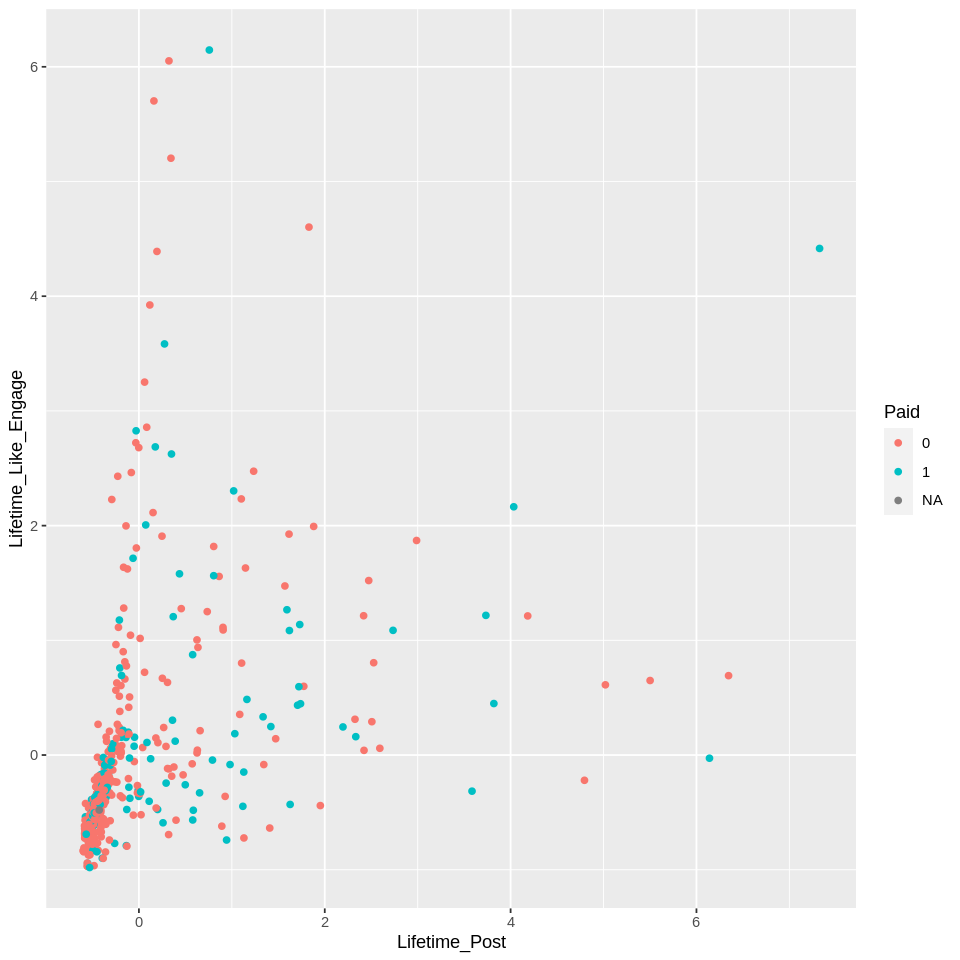

In [10]:
#plotting the scaled variables
facebook_plot <- ggplot(facebook_scaled, aes(x = Lifetime_Post, y = Lifetime_Like_Engage, colour = Paid)) +
    geom_point()
facebook_plot

In [11]:
#predicting new observations
facebook_fit_new <- workflow() %>%
    add_recipe(facebook_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = facebook_scaled)

new_obs <- tibble(Lifetime_Post = 1, Lifetime_Like_Engage = 0.5)

facebook_predict <- predict(facebook_fit_new, new_obs)
facebook_predict

.pred_class
<fct>
1


### Discussion:

### Reference: